In [ ]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import BertTokenizer, BertForSequenceClassification, RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.preprocessing import LabelEncoder

# Load the dataset
df = pd.read_excel('/content/dataset_final.xlsx')

# Print out the column names to inspect them
print("Columns in the dataset:", df.columns)

# Replace 'Question' and 'Discipline' with your actual column names
df = df[['Question', 'Discipline']]  # Assuming 'Question' is text and 'Discipline' is the label column
# Remove rows with missing values
df = df.dropna()

# Label Encoding for the 'Discipline' column
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['Discipline'])

# Train-Test Split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Convert the data to HuggingFace Dataset format
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

# Define function to load models and tokenizers
def load_model_and_tokenizer(model_name):
    if model_name.startswith('bert'):
        tokenizer = BertTokenizer.from_pretrained(model_name)
        model = BertForSequenceClassification.from_pretrained(model_name, num_labels=df['label'].nunique())
    elif model_name.startswith('roberta'):
        tokenizer = RobertaTokenizer.from_pretrained(model_name)
        model = RobertaForSequenceClassification.from_pretrained(model_name, num_labels=df['label'].nunique())
    return tokenizer, model

# Tokenization Function
def tokenize_function(examples, tokenizer):
    return tokenizer(examples['Question'], padding='max_length', truncation=True)

# Define function for metrics (Accuracy, Precision, Recall, F1)
def compute_metrics(p):
    preds = p.predictions.argmax(axis=-1)
    labels = p.label_ids
    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# Define function to train and evaluate the model
def train_and_evaluate(model_name, batch_size=8, learning_rate=2e-5, epochs=3):
    # Load model and tokenizer
    tokenizer, model = load_model_and_tokenizer(model_name)

    # Tokenize the datasets
    train_tokenized = train_dataset.map(lambda x: tokenize_function(x, tokenizer), batched=True)
    test_tokenized = test_dataset.map(lambda x: tokenize_function(x, tokenizer), batched=True)

    # Ensure 'Discipline' is encoded as 'labels'
    train_tokenized = train_tokenized.rename_column('label', 'labels')
    test_tokenized = test_tokenized.rename_column('label', 'labels')

    # Set format for PyTorch (ensure 'labels' is included)
    target_columns = ['input_ids', 'attention_mask', 'labels']
    train_tokenized.set_format(type='torch', columns=target_columns)
    test_tokenized.set_format(type='torch', columns=target_columns)

    # Define Training Arguments
    training_args = TrainingArguments(
        output_dir='./results',
        evaluation_strategy='epoch',
        learning_rate=learning_rate,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=epochs,
        weight_decay=0.01,
        report_to="none"  # Avoid logging to Weights & Biases for now
    )

    # Initialize the Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_tokenized,
        eval_dataset=test_tokenized,
        compute_metrics=compute_metrics
    )

    # Train the model
    trainer.train()

    # Evaluate the model
    eval_results = trainer.evaluate()
    print(f"Evaluation Results for {model_name}:")
    print(eval_results)  # Print out the evaluation results for comparison

# Experiment with different hyperparameters and models
print("Training BERT model...")
train_and_evaluate('bert-base-uncased', batch_size=8, learning_rate=2e-5, epochs=3)

print("\nTraining RoBERTa model...")
train_and_evaluate('roberta-base', batch_size=8, learning_rate=2e-5, epochs=3)

# Hyperparameter Tuning Example:
# You can experiment with different learning rates, batch sizes, and epochs

print("\nTraining BERT with a different learning rate (1e-5)...")
train_and_evaluate('bert-base-uncased', batch_size=8, learning_rate=1e-5, epochs=3)

print("\nTraining RoBERTa with a different batch size (16)...")
train_and_evaluate('roberta-base', batch_size=16, learning_rate=2e-5, epochs=3)


Columns in the dataset: Index(['Discipline', 'Question', 'Reason you think it is faulty',
       'Which top LLM you tried ', 'Response by a top LLM '],
      dtype='object')
Training BERT model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/3523 [00:00<?, ? examples/s]

Map:   0%|          | 0/881 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.106109,0.972758,0.973133,0.972758,0.972652
2,0.638100,0.022496,0.996595,0.996635,0.996595,0.996595
3,0.045900,0.008076,0.996595,0.996712,0.996595,0.996595


Evaluation Results for bert-base-uncased:
{'eval_loss': 0.00807610247284174, 'eval_accuracy': 0.996594778660613, 'eval_precision': 0.9967122000861091, 'eval_recall': 0.996594778660613, 'eval_f1': 0.996594778660613, 'eval_runtime': 24.5358, 'eval_samples_per_second': 35.907, 'eval_steps_per_second': 4.524, 'epoch': 3.0}

Training RoBERTa model...


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/3523 [00:00<?, ? examples/s]

Map:   0%|          | 0/881 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.123770,0.975028,0.975289,0.975028,0.974973
2,0.474500,0.031269,0.994325,0.994495,0.994325,0.994325
3,0.073400,0.026152,0.992054,0.992068,0.992054,0.992042


Evaluation Results for roberta-base:
{'eval_loss': 0.02615249902009964, 'eval_accuracy': 0.9920544835414302, 'eval_precision': 0.9920684967979709, 'eval_recall': 0.9920544835414302, 'eval_f1': 0.9920419204634546, 'eval_runtime': 22.4536, 'eval_samples_per_second': 39.237, 'eval_steps_per_second': 4.944, 'epoch': 3.0}

Training BERT with a different learning rate (1e-5)...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/3523 [00:00<?, ? examples/s]

Map:   0%|          | 0/881 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.231522,0.965948,0.968083,0.965948,0.965728
2,1.016400,0.074031,0.985244,0.986005,0.985244,0.985224
3,0.103300,0.039929,0.992054,0.992451,0.992054,0.992051


Evaluation Results for bert-base-uncased:
{'eval_loss': 0.03992909938097, 'eval_accuracy': 0.9920544835414302, 'eval_precision': 0.9924511059372279, 'eval_recall': 0.9920544835414302, 'eval_f1': 0.9920512131694477, 'eval_runtime': 24.4949, 'eval_samples_per_second': 35.967, 'eval_steps_per_second': 4.532, 'epoch': 3.0}

Training RoBERTa with a different batch size (16)...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/3523 [00:00<?, ? examples/s]

Map:   0%|          | 0/881 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.115379,0.969353,0.970820,0.969353,0.969288
2,No log,0.045972,0.990919,0.991284,0.990919,0.990917
3,0.367200,0.015079,0.996595,0.996635,0.996595,0.996595


Evaluation Results for roberta-base:
{'eval_loss': 0.015079336240887642, 'eval_accuracy': 0.996594778660613, 'eval_precision': 0.9966354995355018, 'eval_recall': 0.996594778660613, 'eval_f1': 0.9965951798214873, 'eval_runtime': 22.9924, 'eval_samples_per_second': 38.317, 'eval_steps_per_second': 2.436, 'epoch': 3.0}


In [ ]:
from transformers import get_scheduler

# Define function for hyperparameter search and scheduler usage
def train_with_scheduler(model_name, batch_size=8, learning_rate=2e-5, epochs=3):
    # Load model and tokenizer
    tokenizer, model = load_model_and_tokenizer(model_name)

    # Tokenize the datasets
    train_tokenized = train_dataset.map(lambda x: tokenize_function(x, tokenizer), batched=True)
    test_tokenized = test_dataset.map(lambda x: tokenize_function(x, tokenizer), batched=True)

    # Ensure 'Discipline' is encoded as 'labels'
    train_tokenized = train_tokenized.rename_column('label', 'labels')
    test_tokenized = test_tokenized.rename_column('label', 'labels')

    # Set format for PyTorch (ensure 'labels' is included)
    target_columns = ['input_ids', 'attention_mask', 'labels']
    train_tokenized.set_format(type='torch', columns=target_columns)
    test_tokenized.set_format(type='torch', columns=target_columns)

    # Define Training Arguments with a learning rate scheduler
    training_args = TrainingArguments(
        output_dir='./results',
        evaluation_strategy='epoch',
        learning_rate=learning_rate,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=epochs,
        weight_decay=0.01,
        warmup_steps=500,  # Set number of warmup steps
        logging_dir='./logs',  # Logging to track experiment
        report_to="none"
    )

    # Initialize the Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_tokenized,
        eval_dataset=test_tokenized,
        compute_metrics=compute_metrics
    )

    # Set up learning rate scheduler (Linear scheduler in this case)
    trainer.train()  # Training with scheduler in place

    # Evaluate the model
    eval_results = trainer.evaluate()
    print(f"Evaluation Results for {model_name}:")
    print(eval_results)


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load dataset
df = pd.read_excel('/content/dataset_final.xlsx')

# Columns inspection
print("Columns in the dataset:", df.columns)


Columns in the dataset: Index(['Discipline', 'Question', 'Reason you think it is faulty',
       'Which top LLM you tried ', 'Response by a top LLM '],
      dtype='object')


In [4]:
# Preprocessing
df = df[['Question', 'Discipline']]
df = df.dropna()


In [5]:
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['Discipline'])


In [6]:
# Train-test split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Save to CSV to load in the training notebook
train_df.to_csv('/content/train_preprocessed.csv', index=False)
test_df.to_csv('/content/test_preprocessed.csv', index=False)


In [7]:
import joblib

joblib.dump(label_encoder, '/content/label_encoder.pkl')


['/content/label_encoder.pkl']

In [9]:
pip install transformers datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [10]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset
import joblib


In [11]:
# Load preprocessed data
train_df = pd.read_csv('/content/train_preprocessed.csv')
test_df = pd.read_csv('/content/test_preprocessed.csv')

# Load label encoder if needed
label_encoder = joblib.load('/content/label_encoder.pkl')


In [12]:
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)


In [13]:
def load_model_and_tokenizer(model_name):
    if model_name.startswith('bert'):
        tokenizer = BertTokenizer.from_pretrained(model_name)
        model = BertForSequenceClassification.from_pretrained(model_name, num_labels=train_df['label'].nunique())
    return tokenizer, model

tokenizer, model = load_model_and_tokenizer('bert-base-uncased')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
def tokenize_function(examples, tokenizer):
    return tokenizer(examples['Question'], padding='max_length', truncation=True)

train_tokenized = train_dataset.map(lambda x: tokenize_function(x, tokenizer), batched=True)
test_tokenized = test_dataset.map(lambda x: tokenize_function(x, tokenizer), batched=True)

# Rename 'label' to 'labels'
train_tokenized = train_tokenized.rename_column('label', 'labels')
test_tokenized = test_tokenized.rename_column('label', 'labels')

# Set format for PyTorch
target_columns = ['input_ids', 'attention_mask', 'labels']
train_tokenized.set_format(type='torch', columns=target_columns)
test_tokenized.set_format(type='torch', columns=target_columns)


Map:   0%|          | 0/3523 [00:00<?, ? examples/s]

Map:   0%|          | 0/881 [00:00<?, ? examples/s]

In [15]:
from transformers import get_scheduler, TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    warmup_steps=500,
    logging_dir='./logs',
    logging_steps=50,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=test_tokenized
)

# Train and Evaluate
print("Starting training...")
trainer.train()
print("Training completed. Starting evaluation...")
eval_results = trainer.evaluate()
print(f"Evaluation Results: {eval_results}")


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Starting training...


Epoch,Training Loss,Validation Loss
1,0.536900,0.243628
2,0.069100,0.047029
3,0.006600,0.011637


Training completed. Starting evaluation...


Evaluation Results: {'eval_loss': 0.011636736802756786, 'eval_runtime': 26.1909, 'eval_samples_per_second': 33.638, 'eval_steps_per_second': 4.238, 'epoch': 3.0}


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report


In [17]:
# Generate predictions on the test set
predictions = trainer.predict(test_tokenized)

# Extract the predicted labels and true labels
preds = np.argmax(predictions.predictions, axis=-1)
true_labels = predictions.label_ids

# Print classification report for detailed metrics
print(classification_report(true_labels, preds, target_names=label_encoder.classes_))


                  precision    recall  f1-score   support

       Astronomy       1.00      1.00      1.00        92
         Biology       1.00      0.99      0.99        87
       Chemistry       1.00      1.00      1.00        75
Computer Science       1.00      1.00      1.00        83
   Environmental       1.00      1.00      1.00        70
         Geology       1.00      1.00      1.00        72
     Mathematics       1.00      1.00      1.00        70
        Medicine       0.99      0.99      0.99        84
         Physics       1.00      1.00      1.00        99
      Psychology       0.99      1.00      0.99        80
      Statistics       1.00      1.00      1.00        69

        accuracy                           1.00       881
       macro avg       1.00      1.00      1.00       881
    weighted avg       1.00      1.00      1.00       881



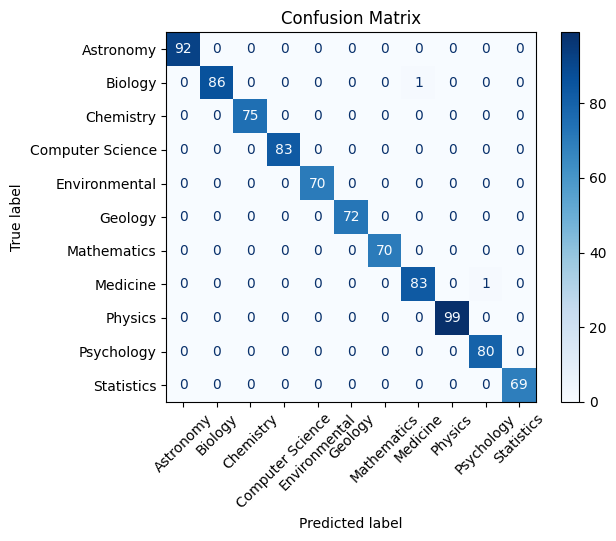

In [18]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, preds)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title('Confusion Matrix')
plt.show()
